# Predicting Tesla (TSLA) Buy/Sell and Analysis

Company Background:

Tesla (TSLA), is an American Automobile company who is known for their all electric vehicles. They have started to enter the stock market in 2010 starting at $19-$24/share. This company has raised the bar to promote all electric in an effort to make disel gas a thing of the past. Not only cars Tesla manufactures, they also produce solar panels, charging at home stations as well as adding electric recharge stations. As of current, Tesla is at a market value of $803.33/share on the NASDAQ Exchange.

Discussion:

In this analysis, I will be analyzing their buy/sell trend. The purpose of this analysis will be looking at the potential to whether Tesla would predict a Buy(1) or Sell(-1). To aid in predicting the buy or sell strategy, I will be deploying the following Machine Learning Packages and Libraries.

- Pandas: Used for Data Manipulation and Importing Dataset
- YFinance: Yahoo Finance API to get historical stock data from Yahoo Finance servers
- Numpy: Used for converting from a DataFrame into an array
- Matplotlib: Utilized for the purposes of plotting a graph for Data Visualization
- Sklearn: Machine Learning library used for the purposes of classification, regression, and clustering algorithms
- Talib: Used for Technical Analysis, such as RSI (Relative Strength Index), Difference in Open price of yesterday and today, and difference in Open, Close, High, Low. This is widely used by Software Traders who do alot of analysis on financial market data. 

In [297]:
#Importing Packages
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

#Technical Analysis
import talib as ta

#Machine Learning Packages
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Getting Historical Stock Data From Yahoo Finance API
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [298]:
#Importing Stock Data Using Ticker Symbol 'TSLA'
tsla = pdr.get_data_yahoo('TSLA', '2010-05-13','2020-05-13')
tsla = tsla.dropna()
tsla = tsla.iloc[:,:4]
tsla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001


In [299]:
#Defining Variables and Prediction Signals

tsla['S_10'] = tsla['Close'].rolling(window=30).mean()
tsla['Corr'] = tsla['Close'].corr(tsla['S_10'])
tsla['RSI'] = ta.RSI(np.array(tsla['Close']), timeperiod =30)
tsla['Open-Close'] = tsla['Open'] - tsla['Close'].shift(1)
tsla['Open-Close'] = tsla['Open'] - tsla['Open'].shift(1)
tsla = tsla.dropna()
X = tsla.iloc[:,:9]

In [300]:
y = np.where(tsla['Close'].shift(-1) > tsla['Close'],1,-1)

Below, The dataset has been split into 30% Train and 70% Testing

In [301]:
#Splitting Dataset into Testing and Training

split = int(0.3*len(tsla))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [302]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

In [303]:
#Examining the Dataset Coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[0.18918375377119304]
1,High,[-0.05941751723994808]
2,Low,[-0.36566696161892615]
3,Close,[0.1963202389083372]
4,S_10,[0.051380914552973424]
5,Corr,[0.022135177524961032]
6,RSI,[-0.009826476427987887]
7,Open-Close,[-0.05533955377660647]


In [304]:
#Getting the Model Probability
probability = model.predict_proba(X_test)
print (probability)

[[1.85028390e-02 9.81497161e-01]
 [1.14880403e-02 9.88511960e-01]
 [3.17226969e-01 6.82773031e-01]
 ...
 [7.09640902e-04 9.99290359e-01]
 [6.21563377e-04 9.99378437e-01]
 [6.36788585e-02 9.36321141e-01]]


In [305]:
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)

[[1.85028390e-02 9.81497161e-01]
 [1.14880403e-02 9.88511960e-01]
 [3.17226969e-01 6.82773031e-01]
 ...
 [7.09640902e-04 9.99290359e-01]
 [6.21563377e-04 9.99378437e-01]
 [6.36788585e-02 9.36321141e-01]]


In [306]:
print(metrics.confusion_matrix(y_test, predicted))

[[  7 835]
 [  4 873]]


Classification Report:

According to the classification report below, we can see that the Accuracy Score under (f1-Score) shows that our Sell (-1) shows a 0.02% whereas the Buy (1) shows a 68% accuracy.   

In [307]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.64      0.01      0.02       842
           1       0.51      1.00      0.68       877

    accuracy                           0.51      1719
   macro avg       0.57      0.50      0.35      1719
weighted avg       0.57      0.51      0.35      1719



In [308]:
print(model.score(X_test,y_test))
#This is the Accuracy Score

0.5119255381035486


In [309]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.51219512 0.51219512 0.51626016 0.49593496 0.49186992 0.53877551
 0.53469388 0.49795918 0.49387755 0.44489796]
0.5038659366185498


Buy/Sell Prediction Strategy Graph Output

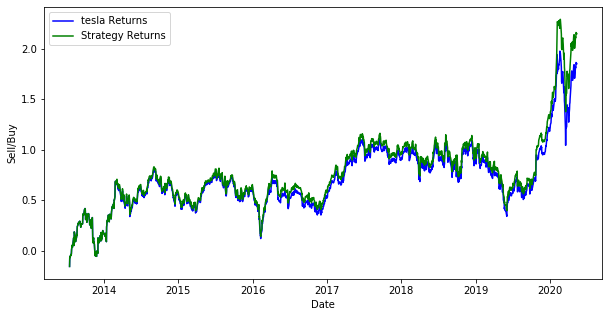

In [310]:
tsla['Predicted_Signal'] = model.predict(X)
tsla['Tesla_returns'] = np.log(tsla['Close']/tsla['Close'].shift(1))
Cumulative_tesla_returns = np.cumsum(tsla[split:]['Tesla_returns'])

tsla['Startegy_returns'] = tsla['Tesla_returns']* tsla['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(tsla[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_tesla_returns, color='b',label = 'tesla Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.ylabel('Sell/Buy')
plt.xlabel('Date')
plt.show()

# Conclusion

In summary, we can conclude that buying Tesla is perferred based on the fact that their current market trends are soaring upward than selling the stock. Tesla has the potential to become a well profitable company in the Auto Industry. Overall, I would buy Tesla because as of current, they stand at $803.33/share and that should attract investors who want to flood capital into the electric vehicle market. Nowadays, electric vehicles start to become more of a trend to curb the enviormental crisis because of carbon emissions from disel vehicles. In the end, Tesla is a great buy to invest if you are a believer in all electric transportation.  